In [19]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import getpass
import sys
sys.path.insert(0, f'/home/{getpass.getuser()}/dowgan/dowgan')
import Util
import tsGAN
#%run -i 'tsGAN.py'

import os

import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
sns.set_style('white')
sns.set_context('poster')

In [21]:
# CSV path
folder_name = "data"
file_name = "hungary_chickenpox.csv"
path = os.path.join('../', folder_name, file_name)
#Load CSV into Dataframe
df = pd.read_csv(path,sep=',')
df = df.drop(columns = ['Date'])

In [22]:
# Get column names
names = Util.get_column_names(df)

In [23]:
#Showing the different counties in Hungary
df.keys()

Index(['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD', 'FEJER',
       'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM', 'NOGRAD', 'PEST', 'SOMOGY',
       'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM', 'ZALA'],
      dtype='object')

In [24]:
# fig, axes = plt.subplots(1,3,figsize=(20,5))

# sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0])
# axes[0].set_xticks(np.arange(0,550,100))
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1])
# axes[1].set_xticks(np.arange(0,550,100))
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2])
# axes[2].set_xticks(np.arange(0,550,100))
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD');

In [25]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 522

# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.005
# number of epoch
num_epochs = 500
# Discriminator and Generator dropout for data standardization
drop_out=0.2
# Define batch size for the data loader
batch_size = 18


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df[:num_data],num_data)
train_set = Util.create_tensors(arrays)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

In [26]:
#Calling the generator and discriminator
generator = tsGAN.Generator(df_dim,batch_size,drop_out)
discriminator =  tsGAN.Discriminator(df_dim,batch_size,drop_out)

In [27]:
#Training the generator and discriminator with the data and returning a list of the losses
dim_list, gen_list = tsGAN.training_loop(generator, discriminator, num_epochs, train_loader, batch_size,lr,df_dim)

Epoch: 0 Loss D.: 0.3350646197795868
Epoch: 0 Loss G.: 0.8421446681022644
Epoch: 10 Loss D.: 0.23714351654052734
Epoch: 10 Loss G.: 2.118134021759033
Epoch: 20 Loss D.: 0.1434718668460846
Epoch: 20 Loss G.: 3.375533103942871
Epoch: 30 Loss D.: 0.0771777555346489
Epoch: 30 Loss G.: 2.2663614749908447
Epoch: 40 Loss D.: 0.6132542490959167
Epoch: 40 Loss G.: 2.4413833618164062
Epoch: 50 Loss D.: 0.36819109320640564
Epoch: 50 Loss G.: 3.076582670211792
Epoch: 60 Loss D.: 0.18969109654426575
Epoch: 60 Loss G.: 1.9710049629211426
Epoch: 70 Loss D.: 0.07218893617391586
Epoch: 70 Loss G.: 2.525951862335205
Epoch: 80 Loss D.: 0.1914205104112625
Epoch: 80 Loss G.: 1.3867583274841309
Epoch: 90 Loss D.: 0.4521733820438385
Epoch: 90 Loss G.: 1.3836679458618164
Epoch: 100 Loss D.: 0.5086657404899597
Epoch: 100 Loss G.: 1.546951413154602
Epoch: 110 Loss D.: 0.2008466124534607
Epoch: 110 Loss G.: 1.5367169380187988
Epoch: 120 Loss D.: 0.26214295625686646
Epoch: 120 Loss G.: 1.5823484659194946
Epoch: 1

In [28]:
#Converting the losses from tensors into a DataFrame

#Initializing the loss lists
dim_list_new = []
gen_list_new = []

#Iterating through the lists of tensors and converting them to arrays
for i in np.arange(0,len(dim_list)):
    d = dim_list[i].detach().numpy()
    g = gen_list[i].detach().numpy()
    dim_list_new.append(d)
    gen_list_new.append(g)

#Putting these loss lists into Dataframes
dim_list_new=pd.DataFrame(dim_list_new, columns=['dim_loss'])
gen_list_new=pd.DataFrame(gen_list_new, columns=['gen_loss'])

loss = pd.concat([dim_list_new,gen_list_new],axis=1)


In [29]:
len(loss)

14500

Text(0.5, 0, 'Step')

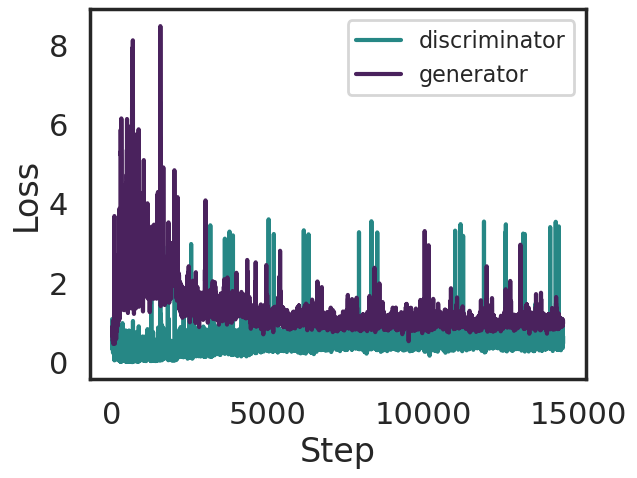

In [30]:
#Plotting the losses of the discriminator and the generator
fig, ax = plt.subplots()

sns.lineplot(data=loss, x=range(0, len(loss)),y='dim_loss',sort=False, label = 'discriminator',color='#268785')
sns.lineplot(data=loss, x=range(0, len(loss)),y='gen_loss',sort=False, label = 'generator',color='#4A225D')

ax.legend(fontsize = 16)
ax.set_ylabel('Loss')
ax.set_xlabel('Step')
#ax.set_ylim(-0.7,1)

In [31]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [32]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples, columns=names)
df_gen

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,307.584290,55.939503,63.373878,160.635971,213.956940,98.998405,180.142426,285.627411,144.443390,129.211380,162.860077,96.755226,2.580426,266.563721,67.513199,97.312904,27.570734,39.493526,146.608429,68.732376
1,97.791359,10.141256,52.219124,6.291767,70.766243,34.485313,23.162445,27.397030,19.481007,7.435954,25.963503,7.455886,33.717529,70.758163,6.945682,24.130100,4.569553,22.600847,51.718872,26.717159
2,10.288707,32.398640,35.738018,-0.893910,104.717155,-4.081922,41.948193,10.977801,43.657799,-3.593874,27.289837,43.414951,28.775738,38.242264,1.969014,36.474560,7.073112,4.335299,9.099628,9.069308
3,20.140188,-1.133053,-1.904871,1.951510,-3.173711,23.057913,23.104513,7.757923,27.935331,33.840412,-9.262342,8.339565,11.168159,65.598625,1.308717,2.314836,7.893669,10.423128,-3.564941,23.586929
4,269.025696,36.724228,105.592575,28.049458,135.760162,81.896683,21.578182,63.221645,62.391235,42.891685,28.205278,12.506555,80.115822,173.854477,50.005981,25.328917,20.632961,13.076416,72.318291,72.432144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,158.336685,51.844685,74.925552,57.801010,142.455032,70.675941,53.668499,37.296806,1.708083,140.543777,99.799889,1.102566,52.363720,113.769928,54.049080,25.855537,14.324032,89.994980,36.934090,74.450974
518,78.728043,-1.667443,32.158669,5.014622,0.631538,37.975971,16.286673,19.788626,12.897905,7.192519,20.020344,-4.637630,7.305492,25.294498,11.899508,39.919449,5.759482,24.255264,-0.634945,1.741120
519,138.792847,62.275723,83.887489,74.029953,159.674454,65.420799,103.249603,87.053185,34.275486,125.013634,162.899277,65.083572,42.413052,110.429176,52.864475,27.153561,20.454905,61.837135,55.951141,128.324036
520,89.297333,14.485246,23.441448,2.371920,4.019720,1.261377,18.311522,74.544579,33.925961,38.694759,34.493011,30.391384,28.568188,186.935013,35.107155,6.954750,31.342823,23.368568,33.720119,22.350731


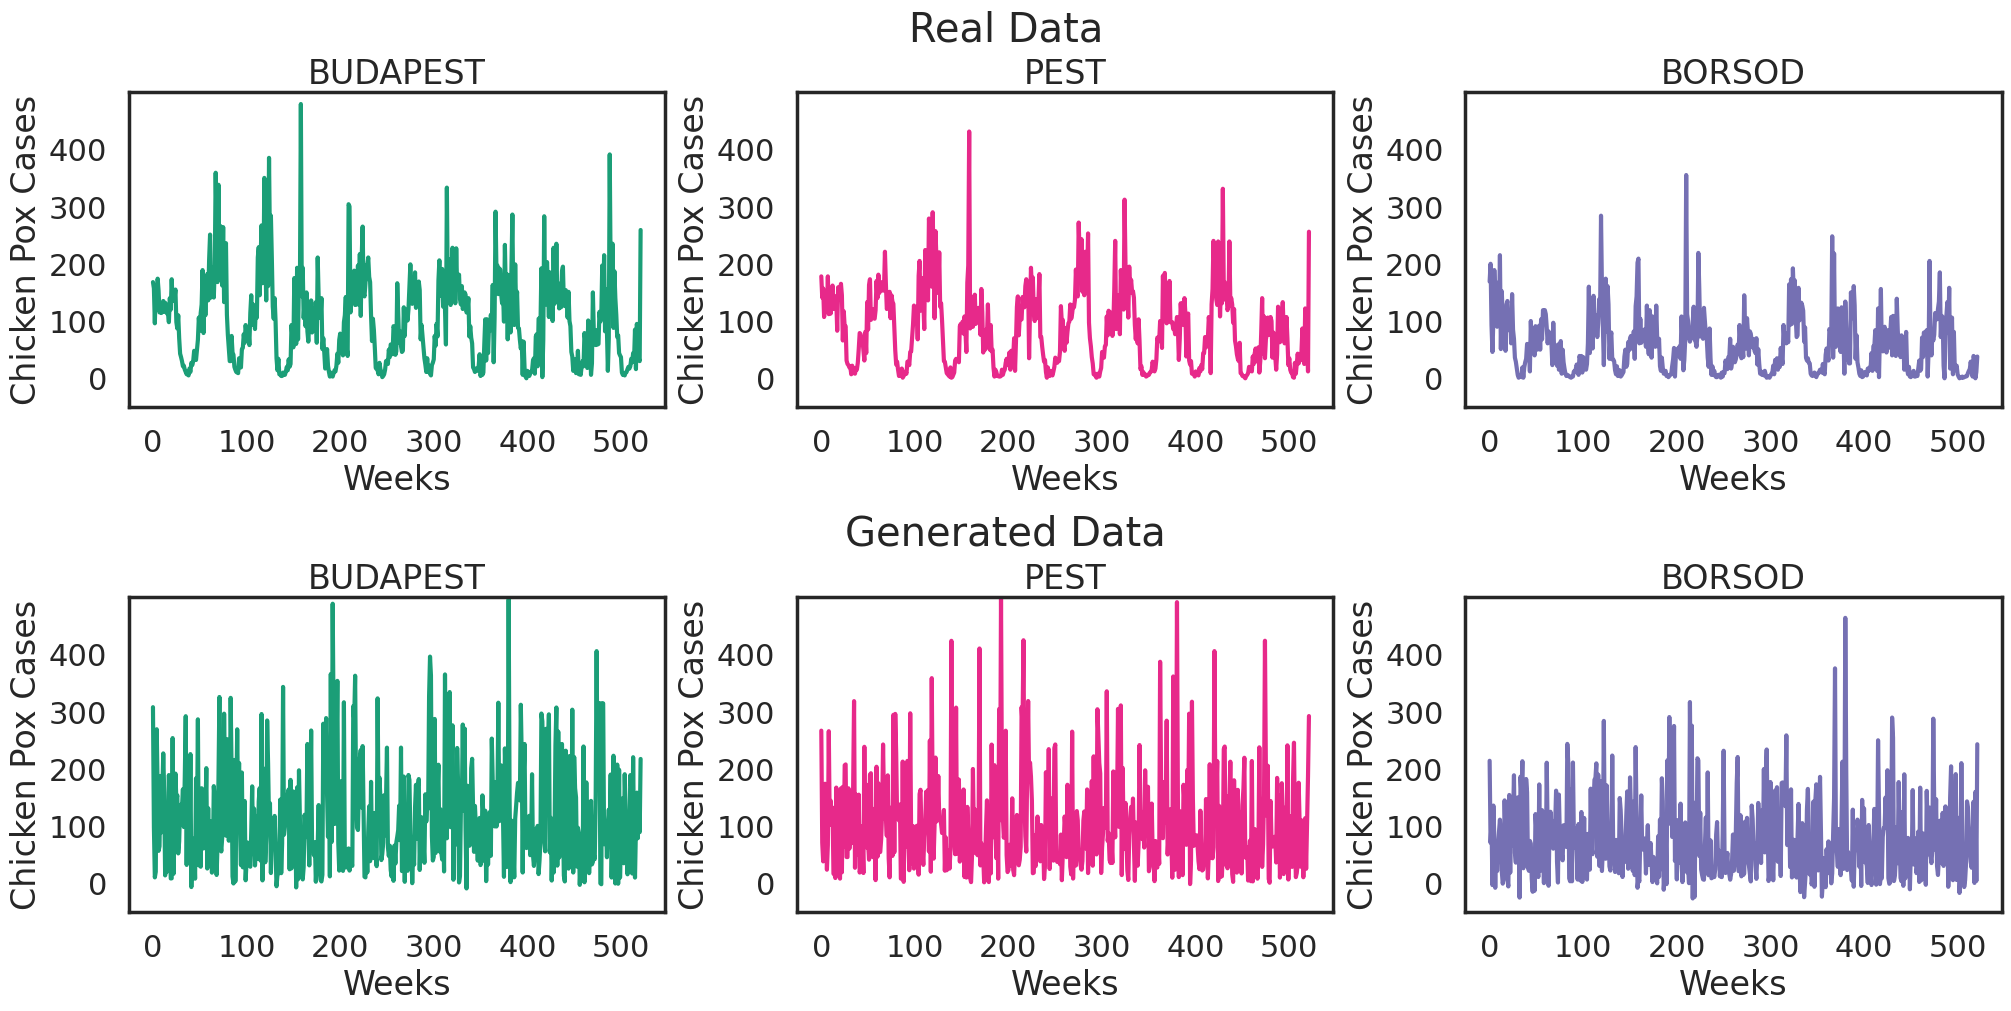

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df, df_gen]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.lineplot(data=df_list[row],x=df.iloc[0:].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,550,100))
        ax.set_ylim(-50, 500)
        ax.set_yticks(np.arange(0,500,100))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')

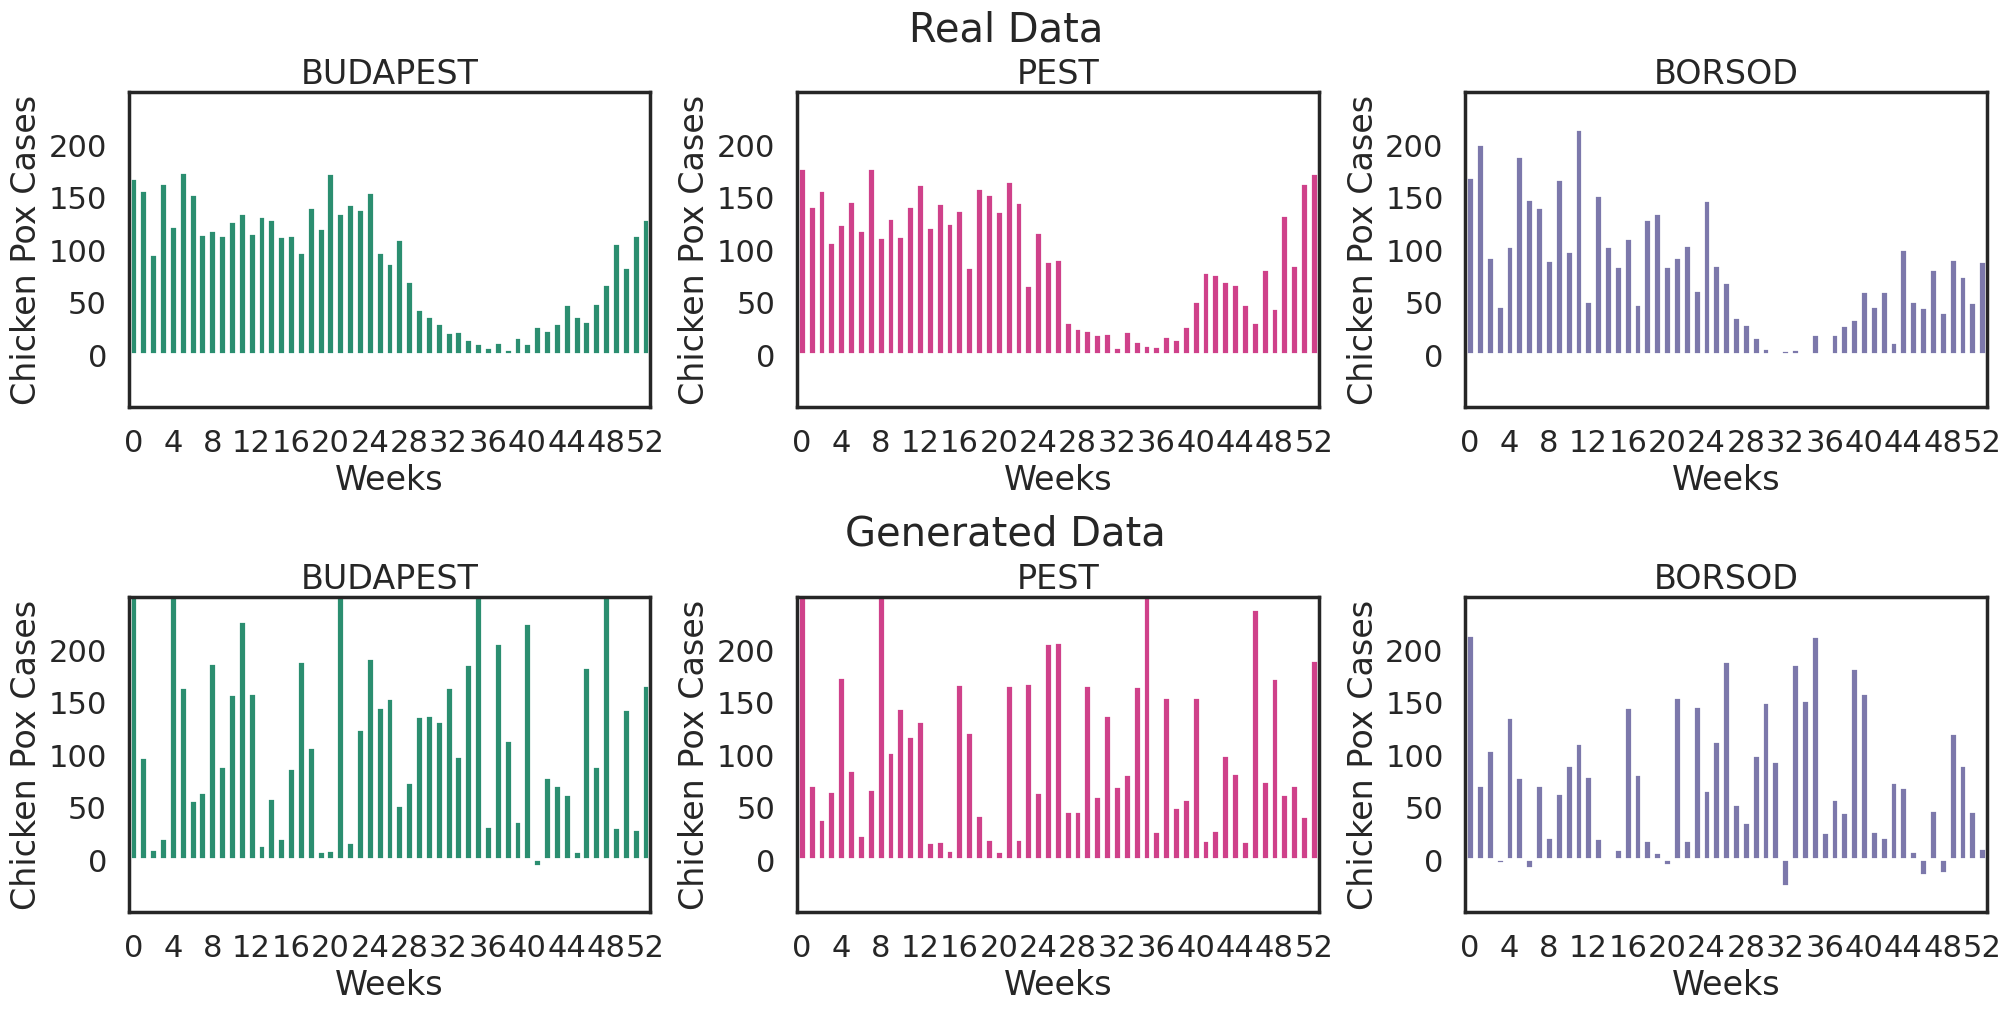

In [34]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
#fig.suptitle('Real vs. Generated Data')

df_list = [df.head(53), df_gen.head(53)]
colors = ['#1b9e77','#e7298a', '#7570b3']
sub_titles = ['Real Data', 'Generated Data']
plot_titles = ['BUDAPEST', 'PEST', 'BORSOD']

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(sub_titles[row])

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        sns.barplot(data=df_list[row],x=df.iloc[0:53].index,y=plot_titles[col], ax=axs[col], color=colors[col], alpha=1)
        ax.set_title(plot_titles[col])
        ax.set_xticks(np.arange(0,53,4))
        ax.set_ylim(-50, 250)
        ax.set_yticks(np.arange(0,250,50))
        ax.set_xlabel('Weeks')
        ax.set_ylabel('Chicken Pox Cases')


In [35]:
# sns.set_style('white')
# sns.set_context('talk')
# fig, axes = plt.subplots(1,3, figsize=(20,5))
# #fig.tight_layout()

# sns.lineplot(data=df_gen, x=df.index, y='BUDAPEST', ax=axes[0])
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1])
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2])
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD')

In [36]:
# fig, axes = plt.subplots(1,3,figsize=(20,5))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.3)

# sns.lineplot(data=df,x=df.index,y='BUDAPEST',ax=axes[0], color='#373c38', alpha=1, label='Real')
# sns.lineplot(data=df_gen,x=df.index,y='BUDAPEST',ax=axes[0], color='#1b9e77', alpha=0.75, label='Generated')
# axes[0].set_xticks(np.arange(0,550,100))
# axes[0].set_xlabel('Weeks')
# axes[0].set_ylabel('Chicken Pox Cases')
# axes[0].set_title('BUDAPEST')

# sns.lineplot(data=df,x=df.index,y='PEST',ax=axes[1], color='#373c38', label='Real')
# sns.lineplot(data=df_gen, x=df.index, y='PEST', ax=axes[1], color='#e7298a', alpha=0.75, label='Generated')
# axes[1].set_xticks(np.arange(0,550,100))
# axes[1].set_xlabel('Weeks')
# axes[1].set_ylabel('Chicken Pox Cases')
# axes[1].set_title('PEST')

# sns.lineplot(data=df,x=df.index,y='BORSOD',ax=axes[2], color='#373c38', label='Real')
# sns.lineplot(data=df_gen, x=df.index, y='BORSOD', ax=axes[2], color='#7570b3', alpha=0.75, label='Generated')
# axes[2].set_xticks(np.arange(0,550,100))
# axes[2].set_xlabel('Weeks')
# axes[2].set_ylabel('Chicken Pox Cases')
# axes[2].set_title('BORSOD');

In [37]:
# fig, axes = plt.subplots(2,3,figsize=(20,10))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.3)

# subfigs = fig.subfigures

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BUDAPEST'].head(53),ax=axes[0,0], color='#373c38', alpha=1, label='Real')
# axes[0,0].set_xticks(np.arange(0,53,4))
# axes[0,0].set_xlabel('Weeks')
# axes[0,0].set_ylabel('Chicken Pox Cases')
# axes[0,0].set_title('BUDAPEST')

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['PEST'].head(53),ax=axes[0,1], color='#373c38', label='Real')
# axes[0,1].set_xticks(np.arange(0,53,4))
# axes[0,1].set_xlabel('Weeks')
# axes[0,1].set_ylabel('Chicken Pox Cases')
# axes[0,1].set_title('PEST')

# sns.barplot(data=df,x=df.iloc[0:53].index,y=df['BORSOD'].head(53),ax=axes[0,2], color='#373c38', label='Real')
# axes[0,2].set_xticks(np.arange(0,53,4))
# axes[0,2].set_xlabel('Weeks')
# axes[0,2].set_ylabel('Chicken Pox Cases')
# axes[0,2].set_title('BORSOD')

# sns.barplot(data=df_gen,x=df.iloc[0:53].index,y=df_gen['BUDAPEST'].head(53),ax=axes[1,0], color='#1b9e77', alpha=0.75, label='Generated')
# axes[1,0].set_xticks(np.arange(0,53,4))
# axes[1,0].set_xlabel('Weeks')
# axes[1,0].set_ylabel('Chicken Pox Cases')

# sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['PEST'].head(53), ax=axes[1,1], color='#e7298a', alpha=0.75, label='Generated')
# axes[1,1].set_xticks(np.arange(0,53,4))
# axes[1,1].set_xlabel('Weeks')
# axes[1,1].set_ylabel('Chicken Pox Cases')

# sns.barplot(data=df_gen, x=df.iloc[0:53].index, y=df_gen['BUDAPEST'].head(53), ax=axes[1,2], color='#7570b3', alpha=0.75, label='Generated')
# axes[1,2].set_xticks(np.arange(0,53,4))
# axes[1,2].set_xlabel('Weeks')
# axes[1,2].set_ylabel('Chicken Pox Cases')

Epoch: 0 Loss D.: 0.3350646197795868
Epoch: 0 Loss G.: 0.8421446681022644
Epoch: 10 Loss D.: 0.23714351654052734
Epoch: 10 Loss G.: 2.118134021759033
Epoch: 20 Loss D.: 0.1434718668460846
Epoch: 20 Loss G.: 3.375533103942871
Epoch: 30 Loss D.: 0.0771777555346489
Epoch: 30 Loss G.: 2.2663614749908447
Epoch: 40 Loss D.: 0.6132542490959167
Epoch: 40 Loss G.: 2.4413833618164062
Epoch: 50 Loss D.: 0.36819109320640564
Epoch: 50 Loss G.: 3.076582670211792
Epoch: 60 Loss D.: 0.18969109654426575
Epoch: 60 Loss G.: 1.9710049629211426
Epoch: 70 Loss D.: 0.07218893617391586
Epoch: 70 Loss G.: 2.525951862335205
Epoch: 80 Loss D.: 0.1914205104112625
Epoch: 80 Loss G.: 1.3867583274841309
Epoch: 90 Loss D.: 0.4521733820438385
Epoch: 90 Loss G.: 1.3836679458618164
Epoch: 100 Loss D.: 0.5086657404899597
Epoch: 100 Loss G.: 1.546951413154602
Epoch: 110 Loss D.: 0.2008466124534607
Epoch: 110 Loss G.: 1.5367169380187988
Epoch: 120 Loss D.: 0.26214295625686646
Epoch: 120 Loss G.: 1.5823484659194946
Epoch: 1

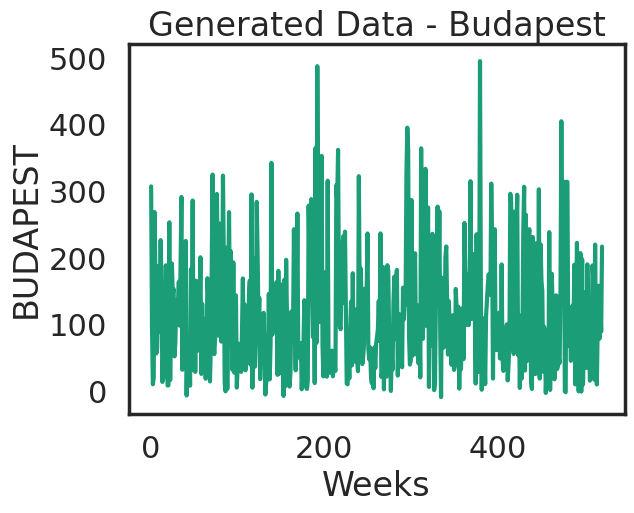

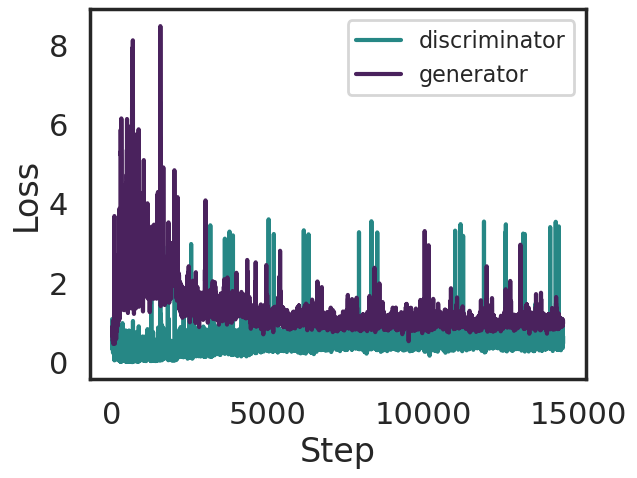

In [38]:
sys.path.insert(0, f'/home/{getpass.getuser()}/dowgan/scripts')
import dataloader

Text(0, 0.5, 'Generated values')

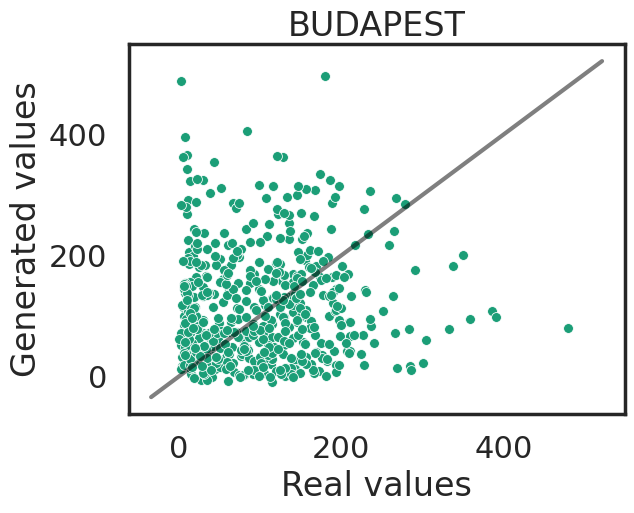

In [39]:
# parity plot of real vs. generated data

fig, ax = plt.subplots()
sns.scatterplot(x=df['BUDAPEST'], y=df_gen['BUDAPEST'], s=50, c='#1b9e77')
lims=ax.get_ylim() # get min and max to make a line
ax.plot(lims, lims, c='black', ls='-', alpha=0.5)
ax.set_title('BUDAPEST')
ax.set_xlabel('Real values')
ax.set_ylabel('Generated values')

In [40]:
import sklearn.metrics
from sklearn.metrics import r2_score

In [41]:
r2_score(df['BUDAPEST'], df_gen['BUDAPEST'])

-1.3815029724198342